In [128]:
import os
import requests
import pystac_client

import numpy as np
from datetime import datetime, timedelta

from urllib.parse import urlparse
from pystac import Asset
from tqdm import tqdm
from typing import List, Optional, Tuple

import rasterio
from rasterio.crs import CRS
from rasterio.warp import transform
from rasterio.windows import from_bounds

pystac_client.__version__

'0.8.6'

In [130]:
service = pystac_client.Client.open('https://data.inpe.br/bdc/stac/v1/')

In [131]:
def download(asset: Asset, directory: str = None, chunk_size: int = 1024 * 16, **request_options) -> str:
     """Smart download STAC Item asset.

#     This method uses a checksum validation and a progress bar to monitor download status.
#     """
     if directory is None:
         directory = ''

     response = requests.get(asset.href, stream=True, **request_options)
     output_file = os.path.join(directory, urlparse(asset.href)[2].split('/')[-1])
     os.makedirs(directory, exist_ok=True)
     total_bytes = int(response.headers.get('content-length', 0))
     with tqdm.wrapattr(open(output_file, 'wb'), 'write', miniters=1, total=total_bytes, desc=os.path.basename(output_file)) as fout:
         for chunk in response.iter_content(chunk_size=chunk_size):
             fout.write(chunk)

In [132]:
def search_items(service: any, bbox: tuple, datetime: str, collections: List[str]) -> Optional[list]:
    """
    Realiza uma busca de itens (imagens de satélite ou dados similares) em uma área geográfica e intervalo de datas específicos.

    Args:
        service (ApiService): Instância do serviço que fornece a API de busca.
        bbox (tuple): Bounding box da área de interesse, na forma (min_longitude, min_latitude, max_longitude, max_latitude).
        datetime (str): Intervalo de datas no formato 'YYYY-MM-DD/YYYY-MM-DD'.
        collections (List[str]): Lista de coleções a serem filtradas.

    Returns:
        Optional[list]: Lista de itens encontrados ou None caso não haja resultados.
    """
    try:
        # Realiza a busca dos itens com os parâmetros fornecidos
        item_search = service.search(bbox=bbox, datetime=datetime, collections=collections)

        # Verifica se há itens encontrados
        if item_search:
            # Retorna os itens encontrados
            return item_search
        else:
            print("Nenhum item encontrado com os parâmetros fornecidos.")
            return None
    except Exception as e:
        print(f"Ocorreu um erro durante a busca: {e}")
        return None

In [136]:
def calculate_nbr(nir_band: np.ndarray, swir_band: np.ndarray) -> np.ndarray:
    """
    Calcula o índice NBR (Normalized Burn Ratio) dado os valores das bandas NIR e SWIR.

    Args:
        nir_band (np.ndarray): Valores da banda Near Infrared (NIR).
        swir_band (np.ndarray): Valores da banda Shortwave Infrared (SWIR).

    Returns:
        np.ndarray: Resultado do cálculo do NBR.
    """
    return (nir_band - swir_band) / (nir_band + swir_band)

def calculate_nbr_difference(service, bbox: tuple, event_date: str, collections: List[str]) -> Optional[float]:
    """
    Calcula a diferença no NBR entre os períodos 7 dias antes e 7 dias depois de uma ocorrência.

    Args:
        service (ApiService): Instância do serviço que fornece a API de busca.
        bbox (tuple): Bounding box da área de interesse, na forma (min_longitude, min_latitude, max_longitude, max_latitude).
        event_date (str): Data do evento no formato 'YYYY-MM-DD'.
        collections (List[str]): Lista de coleções a serem filtradas (ex: ['S2_L2A-1']).

    Returns:
        Optional[float]: Diferença no NBR entre os dois períodos ou None se não for possível calcular.
    """
    try:
        # Converte a string `event_date` para um objeto datetime
        event_date_obj = datetime.strptime(event_date, "%Y-%m-%d")
        
        day_event_before = event_date_obj - timedelta(days=1)
        day_event_above =  event_date_obj + timedelta(days=1)
        
        #Converte para o formato 'YYYY-MM-DD'
        day_event_before_str = day_event_before.strftime("%Y-%m-%d")
        day_event_above_str = day_event_above.strftime("%Y-%m-%d")
        
        # Define os intervalos de 7 dias antes e 7 dias depois do evento
        before_date = event_date_obj - timedelta(days=7)
        after_date = event_date_obj + timedelta(days=7)
        
        # Converte as datas para o formato 'YYYY-MM-DD'
        before_date_str = before_date.strftime("%Y-%m-%d")
        after_date_str = after_date.strftime("%Y-%m-%d")
        
        # Buscar as imagens para o intervalo de 7 dias antes e 7 dias depois do evento
        item_before = search_items(service, bbox, f'{before_date_str}/{day_event_before_str}', collections)
        item_after = search_items(service, bbox, f'{day_event_above_str}/{after_date_str}', collections)
        
        # Se as imagens antes ou depois não forem encontradas
        if not item_before.matched() or not item_after.matched():
            print("Imagens não encontradas para os períodos definidos.")
            return None
        
        # Assumindo que a função `fetch_bands` retorna as bandas NIR e SWIR
        nir_band_before, swir_band_before, nbr_band_before = fetch_bands(item_before, bbox)
        nir_band_after, swir_band_after, nbr_band_after = fetch_bands(item_after, bbox)

        # Calculando o NBR para ambos os períodos
        #nbr_before = calculate_nbr(nir_band_before, swir_band_before)
        #nbr_after = calculate_nbr(nir_band_after, swir_band_after)
        
        # Calculando a diferença no NBR entre os dois períodos
        nbr_diff = nbr_band_after - nbr_band_before
        
        return nbr_diff, nbr_band_after, nbr_band_before

    except Exception as e:
        print(f"Erro ao calcular a diferença no NBR: {e}")
        return None

def read(uri: str, bbox: list, masked: bool = True, crs: str = None):
    """Read raster window as numpy.ma.masked_array."""
    source_crs = CRS.from_string('EPSG:4326')
    if crs:
        source_crs = CRS.from_string(crs)

    # Expects the bounding box has 4 values
    w, s, e, n = bbox
        
    with rasterio.open(uri) as dataset:
        transformer = transform(source_crs, dataset.crs, [w, e], [s, n])
        window = from_bounds(transformer[0][0], transformer[1][0], 
                             transformer[0][1], transformer[1][1], dataset.transform)
        return dataset.read(1, window=window, masked=masked)

def fetch_bands(item_search: List[dict], bbox: tuple) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Extrai as bandas NIR e SWIR de uma busca de itens usando o serviço STAC.
    
    Args:
        item_search (List[dict]): Resultado da busca de itens.
        bbox (tuple): Bounding box para o recorte das imagens.
    
    Returns:
        tuple: Bandas NIR e SWIR, ou None se algum erro ocorrer.
    """
    # Verifica se a lista de itens não está vazia
    if not item_search:
        print("Nenhum item encontrado na busca.")
        return None, None

    # Obtém o primeiro item da busca (ou ajusta para outro critério de item, se necessário)
    item = next(iter(item_search.items()))

    # Verifica se as bandas necessárias estão presentes no item
    
    missing_assets = ['B08', 'B12', 'NBR']
    if any(asset not in item.assets for asset in missing_assets):
        # Ação a ser tomada se algum dos ativos estiver ausente
        print("As bandas NIR (B08), SWIR (B12) ou NBR não estão presentes no item.")
        return None, None, None

    # Lê as bandas NIR e SWIR usando a função auxiliar `read_band`
    nir_band = read(item.assets['B08'].href, bbox)
    swir_band = read(item.assets['B11'].href, bbox)
    nbr_band = read(item.assets['NBR'].href, bbox)

    # Recorta as bandas com base na bbox
    nir_band_cropped = crop_with_bbox(nir_band, bbox)
    swir_band_cropped = crop_with_bbox(swir_band, bbox)

    # Retorna as bandas NIR e SWIR
    return nir_band_cropped, swir_band, nbr_band

#fetch_bands(item_search, bbox)

In [133]:
# Exemplo de chamada do método `search_items`
bbox = (-54.08479949666498, -6.1687900900900905, -53.90360050333502, -5.98860990990991)
datetime = '2024-08-19/2024-09-07'
collections = ['S2-16D-2']

item_search = search_items(service, bbox, datetime, collections)

if item_search:
    print(f"Itens encontrados: {item_search}")
else:
    print("Nenhum item encontrado.")

Itens encontrados: <pystac_client.item_search.ItemSearch object at 0x76e854c915e0>


In [137]:
# Se a busca retornar itens válidos, processa as bandas
if item_search:
    nir_band, swir_band, nbr_band = fetch_bands(item_search, bbox)
    if nir_band is not None and swir_band is not None:
        print("Bandas NIR, SWIR e NBR extraídas com sucesso.")
    else:
        print("Erro ao extrair as bandas NIR ou SWIR.")
else:
    print("Nenhum item encontrado para os parâmetros fornecidos.")

Bandas NIR e SWIR extraídas com sucesso.


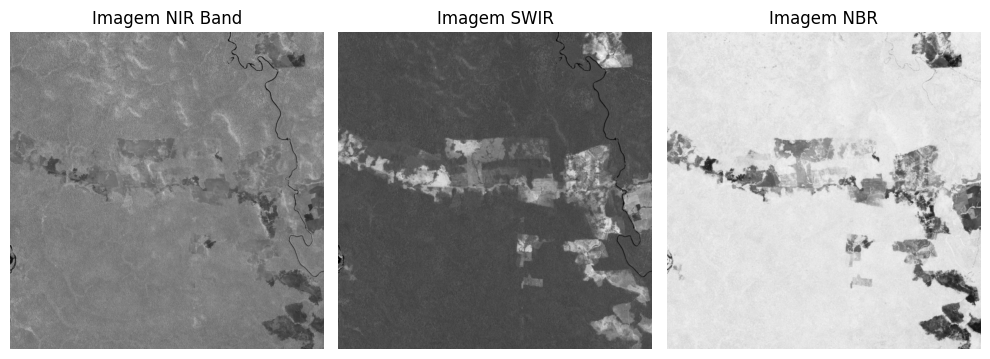

In [114]:
from matplotlib import pyplot as plt

# Suponha que nir_band e nir sejam as imagens que você deseja exibir
# nir_band e nir devem ser arrays NumPy ou qualquer formato adequado para imagens

# Criação do gráfico com 1 linha e 2 colunas para as imagens
fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # 1 linha, 2 colunas

# Plot da primeira imagem (nir_band)
axs[0].imshow(nir_band, cmap='gray')
axs[0].set_title('Imagem NIR Band')
axs[0].axis('off')  # Desativa os eixos para uma visualização mais limpa

# Plot da segunda imagem (nir)
axs[1].imshow(swir_band, cmap='gray')
axs[1].set_title('Imagem SWIR')
axs[1].axis('off')  # Desativa os eixos

# Plot da segunda imagem (nir)
axs[2].imshow(nbr_band, cmap='gray')
axs[2].set_title('Imagem NBR')
axs[2].axis('off')  # Desativa os eixos

# Ajuste de layout
plt.tight_layout()

# Exibe o gráfico
plt.show()

Diferença no NBR entre os dois períodos: -104.09969823734993
Diferença no NBR entre os períodos:


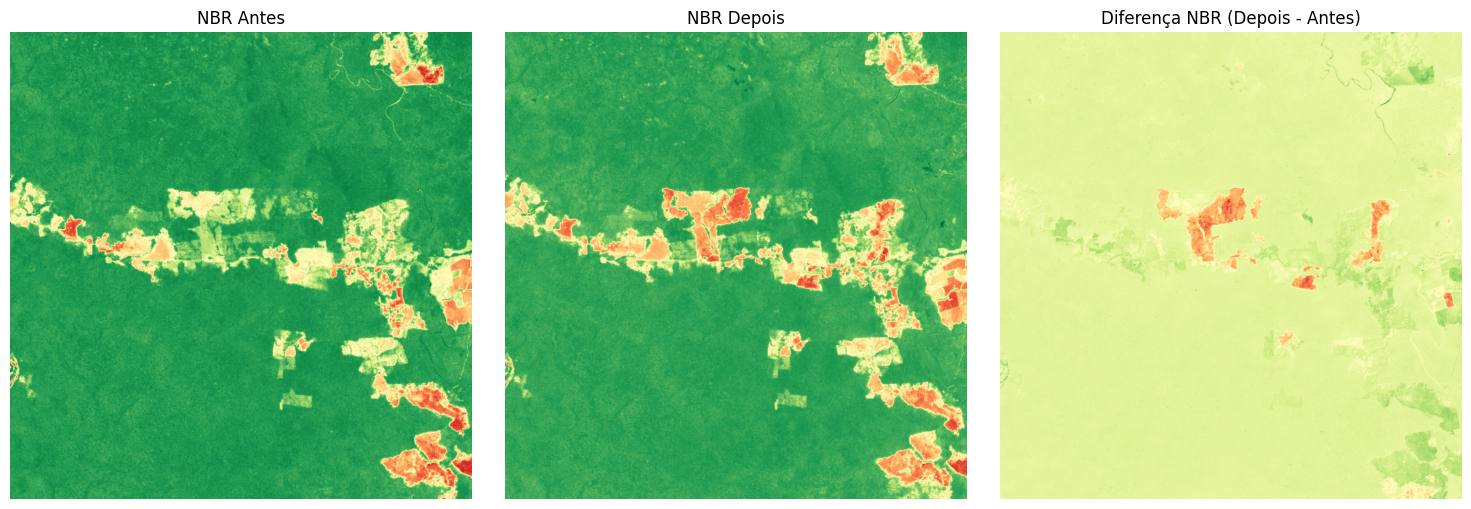

In [119]:
bbox = (-54.08479949666498, -6.1687900900900905, -53.90360050333502, -5.98860990990991)
event_date = '2024-09-08'
collections = ['S2-16D-2']

nbr_diff, nbr_after, nbr_before = calculate_nbr_difference(service, bbox, event_date, collections)

if nbr_diff is not None:
    print(f"Diferença no NBR entre os períodos:")
    # Criar subplots para exibir as imagens
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot do NBR antes
    axs[0].imshow(nbr_before, cmap='RdYlGn')
    axs[0].set_title('NBR Antes')
    axs[0].axis('off')  # Desativa os eixos
    
    # Plot do NBR depois
    axs[1].imshow(nbr_after, cmap='RdYlGn')
    axs[1].set_title('NBR Depois')
    axs[1].axis('off')  # Desativa os eixos
    
    # Plot da diferença entre NBR depois e antes
    axs[2].imshow(nbr_diff, cmap='RdYlGn')
    axs[2].set_title('Diferença NBR (Depois - Antes)')
    axs[2].axis('off')  # Desativa os eixos
    
    # Ajuste do layout para evitar sobreposição
    plt.tight_layout()
    
    # Exibir a visualização
    plt.show()
else:
    print("Não foi possível calcular a diferença no NBR.")